# Demo: Restauração

## Entrada: 
#### -Fotografia danificada
#### -Máscara de fotografia


## Salida:
#### -Fotografia restaurada

### Importando bibliotecas

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

### Parte 1 - Leitura de imagens

In [2]:
rutaFoto = "Pictures/foto25.png"
rutaMascara = "Pictures/mascara25.png"
foto = imageio.imread(rutaFoto)
mascara = imageio.imread(rutaMascara)

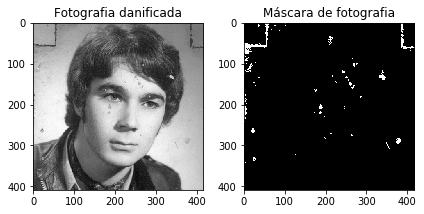

In [3]:
plt.subplot(121)
plt.imshow(foto, cmap=plt.cm.gray)
plt.title("Fotografia danificada")

plt.subplot(122)
plt.imshow(mascara, cmap=plt.cm.gray)
plt.title("Máscara de fotografia")

plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.05,right=0.99)
plt.tight_layout()
plt.show()

### Parte 2 - Restauração

**Sub Parte 2.1 - Interpolação**

In [4]:
def interpolacion(img, mascara):
    # Tamanho das imagens
    N = min(img.shape[0], mascara.shape[0])
    M = min(img.shape[1], mascara.shape[1])
    
    # é equivalente a 'a > b'
    # Qualquer pixel maior que 0 resultará em 'True' para cada pixel de mascara
    Mascara = mascara.__gt__(0)
    
    for i in np.arange(N):
        for j in np.arange(M):
            # Lista de pixels resultantes da interpolação
            pixel = []
            
            # 'True' se o pixel é desconhecida
            if (Mascara[i][j]):
                
                # Interpolação à esquerda
                if (j >= 2):
                    if (mascara[i][j - 1] == 0 and mascara[i][j - 2] == 0):
                        pixel.append(2 * img[i][j - 1] - img[i][j - 2])
                
                # Interpolação à direita
                if (j < M - 2):
                    if (mascara[i][j + 1] == 0 and mascara[i][j + 2] == 0):
                        pixel.append(2 * img[i][j + 1] - img[i][j + 2])
                
                # Interpolação ascendente
                if (i >= 2):
                    if (mascara[i - 1][j] == 0 and mascara[i - 2][j] == 0):
                        pixel.append(2 * img[i - 1][j] - img[i - 2][j])
                
                # Interpolação descendente
                if (i < N - 2):
                    if (mascara[i + 1][j] == 0 and mascara[i + 2][j] == 0):
                        pixel.append(2 * img[i + 1][j] - img[i + 2][j])

                # Interpolação esquina ascendente esquerda
                if (i >= 2 and j >= 2):
                    if (mascara[i - 1][j - 1] == 0 and mascara[i - 2][j - 2] == 0):
                        pixel.append(2 * img[i - 1][j - 1] - img[i - 2][j - 2])

                # Interpolação esquina descendente esquerda
                if (i < N - 2 and j >= 2):
                    if (mascara[i + 1][j - 1] == 0 and mascara[i + 2][j - 2] == 0):
                        pixel.append(2 * img[i + 1][j - 1] - img[i + 2][j - 2])

                # Interpolação esquina ascendente direita
                if (i >= 2 and j < M - 2):
                    if (mascara[i - 1][j + 1] == 0 and mascara[i - 2][j + 2] == 0):
                        pixel.append(2 * img[i - 1][j + 1] - img[i - 2][j + 2])

                # Interpolação esquina descendente direita
                if (i < N - 2 and j < M - 2):
                    if (mascara[i + 1][j + 1] == 0 and mascara[i + 2][j + 2] == 0):
                        pixel.append(2 * img[i + 1][j + 1] - img[i + 2][j + 2])

                # Interpolação bem sucedida pelo menos um
                if (len(pixel) > 0):
                    pixel = np.array(pixel)
                    # Pixel desconhecido é igual à mediana das interpolações
                    img[i][j] = np.uint8(np.median(pixel))
                    # Não é mais um pixel desconhecido
                    Mascara[i][j] = False
    
    # Retorna a imagem e a mascara com os pixels encontrados em preto (0)
    return img, mascara * Mascara

In [5]:
# Testando interpolacion()
print("\nimg para testar: ")
testImg = np.random.randint(256, size=(1, 3))
print(testImg)
print("\nmascara para testar: ")
testMascara = np.array([[255, 0, 0]])
print(testMascara)
# Interpolação à direita
resul = 2 * testImg[0][1] - testImg[0][2]
print("\ntestImg[0][0] = 2 * testImg[0][1] - testImg[0][2] = " + str(resul))
print("\ntestImg[0][0] = " + str(resul%256))
print("\nResultado: ")
testImg, testMascara = interpolacion(testImg, testMascara)
print(testImg)
print(testMascara)


img para testar: 
[[120 171 202]]

mascara para testar: 
[[255   0   0]]

testImg[0][0] = 2 * testImg[0][1] - testImg[0][2] = 140

testImg[0][0] = 140

Resultado: 
[[140 171 202]]
[[0 0 0]]


**Sub Parte 2.2 - Reduzir a resolução**

In [6]:
# Redução através de operadores de produção local (mediana)
def reduccionResolucion(img, n, m):
    # Tamanho de imagem reduzido
    N = int(img.shape[0] / n)
    M = int(img.shape[1] / m)

    if (N > 0 and M > 0):
        if (n == 1 and m == 1):
            return img
        else:
            imgout = np.zeros([N, M])
            for i in np.arange(N):
                # Tamanho do bloco em x
                rx = [i * n, min((i + 1) * n, img.shape[0])]
                for j in np.arange(M):
                    # Tamanho do bloco em y
                    ry = [j * m, min((j + 1) * m, img.shape[1])]
                    # Bloco da imagem 'img' de um tamanho aproximado de 'n*m'
                    bloque = img[rx[0]:rx[1], ry[0]:ry[1]]
                    # Pixel da imagem reduzida é a mediana do bloco
                    imgout[i][j] = np.median(bloque)
            return np.uint8(imgout)
    else:
        return img


img para testar: 
[[219 155]
 [250  18]]

Encomendar os elementos do bloco:
[ 18 155 219 250]

Média dos 2 elementos centrais:
( testOrden[1] + testOrden[2] ) / 2 = ( 155 + 219 ) / 2 = 187

Resultado: 
[[187]]


reduccionResolucion(testImg,4,4):


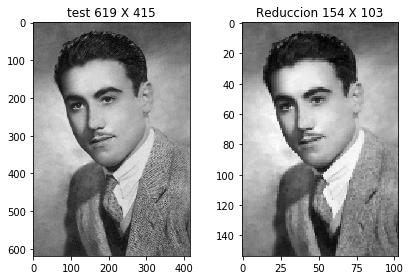

In [7]:
# Testando reduccionResolucion()
print("\nimg para testar: ")
testImg = np.random.randint(256, size=(2, 2))
print(testImg)
# O bloco para selecionar de um tamanho aproximado de 'n*m', neste caso, toda a imagem
# A mediana do bloco
print("\nEncomendar os elementos do bloco:")
testOrden = np.sort(testImg.reshape(-1))
print(testOrden)
print("\nMédia dos 2 elementos centrais:")
resul = (testOrden[1]+testOrden[2])/2
print("( testOrden[1] + testOrden[2] ) / 2 = ( " + str(testOrden[1]) + " + " + str(testOrden[2]) + " ) / 2 = " + str(int(resul)))
print("\nResultado: ")
testImg = reduccionResolucion(testImg,2,2)
print(testImg)

# Testando reduccionResolucion(testImg,4,4)
testImg = imageio.imread("Pictures/test01.png")
print("\n\nreduccionResolucion(testImg,4,4):")
plt.subplot(1, 2, 1)
plt.imshow(testImg, cmap=plt.cm.gray)
plt.title("test " + str(testImg.shape[0]) + " X " + str(testImg.shape[1]))
plt.subplot(1, 2, 2)
testImg = reduccionResolucion(testImg,4,4)
plt.imshow(testImg, cmap=plt.cm.gray)
plt.title("Reduccion " + str(testImg.shape[0]) + " X " + str(testImg.shape[1]))

plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.05, right=0.99)
plt.tight_layout()
plt.show()

**Sub Parte 2.3 - algoritmo da pirâmide de Gaussiana: Interpolação e Redução**

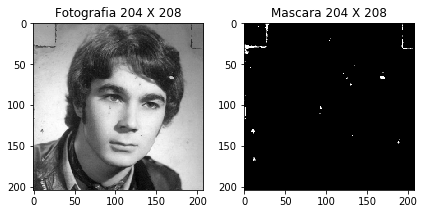

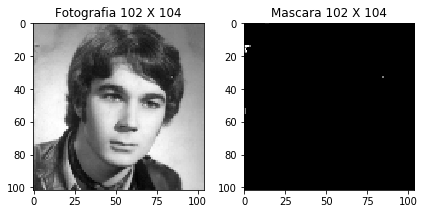

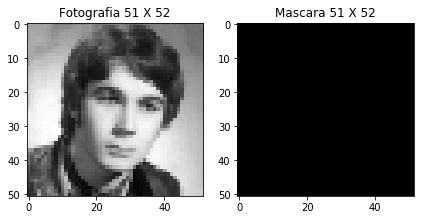

In [8]:
img = foto

# Lista para salvar as imagens que vamos obter
imgP = []
mascaraP = []

pixelesDesconocidos = True

# Enquanto encontra pixels desconhecidos
while (pixelesDesconocidos):
    pixelesDesconocidos = False
    if (np.sum(mascara.__gt__(0)) > 0 and img.shape[0] > 1 and mascara.shape[1] > 1):
        pixelesDesconocidos = True
        
        # Salvar imagens na lista
        imgP.append(img)
        mascaraP.append(mascara)
        
        # Obter a imagem com os novos pixels encontrados pela interpolação e a nova máscara
        img, mascara = interpolacion(img, mascara)
        
        # Reduzir a imagem e a mascara para mitade de largura e longo
        img = reduccionResolucion(img, 2, 2)
        mascara = reduccionResolucion(mascara, 2, 2)
        
        # Mostrando as imagens obtidas após a redução e interpolação
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title("Fotografia " + str(img.shape[0]) + " X " + str(img.shape[1]))
        plt.subplot(1, 2, 2)
        plt.imshow(mascara, cmap=plt.cm.gray)
        plt.title("Mascara " + str(mascara.shape[0]) + " X " + str(mascara.shape[1]))

        plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.05, right=0.99)
        plt.tight_layout()
        plt.show()

**Sub Parte 2.4 - Aumentar a resolução**

In [9]:
#Função cúbica
def cubica(p0, p1, p2, p3, x):
    p0 = int(p0)
    p1 = int(p1)
    p2 = int(p2)
    p3 = int(p3)
    return int(p1 + 0.5 * x * (p2 - p0 + x * (2.0 * p0 - 5.0 * p1 + 4.0 * p2 - p3 + x * (3.0 * (p1 - p2) + p3 - p0))))

In [10]:
# Algoritmo de interpolação bicúbica
def ampliacionResolucion(img, n, m):
    # Tamanho das imagens
    N = img.shape[0]
    M = img.shape[1]
    if ((N > 0 and M > 0) or (n == 1 and m == 1)):
        # Tamanho de imagem ampliado
        N = N * n
        M = M * m
        
        # Envolve a imagem com 1 linha para a direita e 2 para a esquerda
        img = np.concatenate([[img[0, :]], img, [img[-1, :]], [img[-1, :]]], axis=0)

        # Envolve a imagem com 1 linha para cima e 2 para baixo
        img = np.concatenate([np.transpose([img[:, 0]]), img, np.transpose([img[:, -1], img[:, -1]])], axis=1)
        
        imgout = np.zeros([N, M])
        for i in np.arange(N):
            for j in np.arange(M):
                # Obter os índices da imagem original e os decimais
                antX = i / n
                difX = antX - int(antX)
                antX = int(antX)
                
                antY = j / m
                difY = antY - int(antY)
                antY = int(antY)
                
                # Em p obter o cubica() das linhas de um bloco 4 * 4 e difX
                p = np.zeros(4)
                for k in np.arange(4):
                    p[k] = cubica(img[antX + k][antY],
                                  img[antX + k][antY + 1],
                                  img[antX + k][antY + 2],
                                  img[antX + k][antY + 3], difX)
                
                # Obtém o cubica() de p e difY
                imgout[i][j] = cubica(p[0], p[1], p[2], p[3], difY)
        return np.uint8(imgout)
    else:
        return img


img para testar: 
[[253 234 113 193]
 [114 193  45 171]
 [158 181 207 140]
 [180 106 168 163]]

testImg envolto
[[253 253 234 113 193 193 193]
 [253 253 234 113 193 193 193]
 [114 114 193  45 171 171 171]
 [158 158 181 207 140 140 140]
 [180 180 106 168 163 163 163]
 [180 180 106 168 163 163 163]
 [180 180 106 168 163 163 163]]

Para o ponto i = 5 e j = 2
antX=2
difX=0.5
antY=1
difY=0.0

Obter o cubica() das linhas de um bloco 4 * 4
p[0] = cubica(114, 193, 45, 171, 0.5) = 116
p[1] = cubica(158, 181, 207, 140, 0.5) = 199
p[2] = cubica(180, 106, 168, 163, 0.5) = 132
p[3] = cubica(180, 106, 168, 163, 0.5) = 132
testImg[5][2] = cubica(116.0, 199.0, 132.0, 132.0, 0.0) = 199

Resultado: 
[[253 180 234 214 113  68 193 183]
 [251 206 167 136 145 116 198 190]
 [114 125 193 189  45 124 171 152]
 [162 160 116 158  98 133 178 153]
 [158 171 181 142 207 197 140 149]
 [167 153 199 170 175 176 135 145]
 [180 181 106 101 168 165 163 164]
 [139 137 132 127 169 168 162 163]]


ampliacionResolucion(test

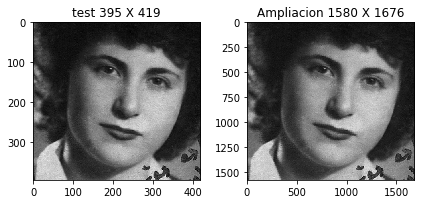

In [11]:
# Testando ampliacionResolucion()
print("\nimg para testar: ")
testImg = np.random.randint(256, size=(4, 4))
print(testImg)

# Envolve a imagem com 1 linha para a direita e 2 para a esquerda
aux = np.concatenate([[testImg[0, :]], testImg, [testImg[-1, :]], [testImg[-1, :]]], axis=0)
# Envolve a imagem com 1 linha para cima e 2 para baixo
aux = np.concatenate([np.transpose([aux[:, 0]]), aux, np.transpose([aux[:, -1], aux[:, -1]])], axis=1)
print("\ntestImg envolto")
print(aux)

print("\nPara o ponto i = 5 e j = 2")
antX = 5 / 2
difX = antX - int(antX)
antX = int(antX)
print("antX="+str(antX))
print("difX="+str(difX))

antY = 2 / 2
difY = antY - int(antY)
antY = int(antY)
print("antY="+str(antY))
print("difY="+str(difY))

print("\nObter o cubica() das linhas de um bloco 4 * 4")
p = np.zeros(4)
for k in np.arange(4):
    print("p[" + str(k) + "] = cubica(" + 
        str(aux[antX + k][antY + 0]) + ", " +
        str(aux[antX + k][antY + 1]) + ", " +
        str(aux[antX + k][antY + 2]) + ", " +
        str(aux[antX + k][antY + 3]) + ", " +
        str(difX) + ") = " +
        str(cubica(aux[antX + k][antY],aux[antX + k][antY + 1],aux[antX + k][antY + 2],aux[antX + k][antY + 3], difX)))
    p[k] = cubica(aux[antX + k][antY],aux[antX + k][antY + 1],aux[antX + k][antY + 2],aux[antX + k][antY + 3], difX)
print("testImg[5][2] = cubica(" + str(p[0]) + ", " +
        str(p[1]) + ", " +
        str(p[2]) + ", " +
        str(p[3]) + ", " +
        str(difY) + ") = " +
        str(cubica(p[0], p[1], p[2], p[3], difY)))

print("\nResultado: ")
testImg = ampliacionResolucion(testImg,2,2)
print(testImg)

# Testando ampliacionResolucion(testImg,4,4)
testImg = imageio.imread("Pictures/test02.png")
print("\n\nampliacionResolucion(testImg,4,4):")
plt.subplot(1, 2, 1)
plt.imshow(testImg, cmap=plt.cm.gray)
plt.title("test " + str(testImg.shape[0]) + " X " + str(testImg.shape[1]))
plt.subplot(1, 2, 2)
testImg = ampliacionResolucion(testImg,4,4)
plt.imshow(testImg, cmap=plt.cm.gray)
plt.title("Ampliacion " + str(testImg.shape[0]) + " X " + str(testImg.shape[1]))

plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.05, right=0.99)
plt.tight_layout()
plt.show()

**Sub Parte 2.5 - algoritmo da pirâmide de Gaussiana: Expansão e inserção dos novos pixels**

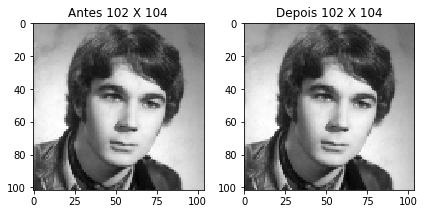

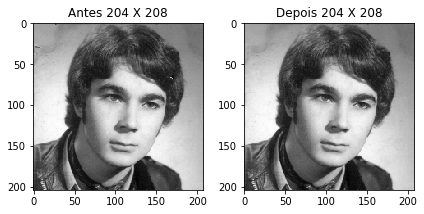

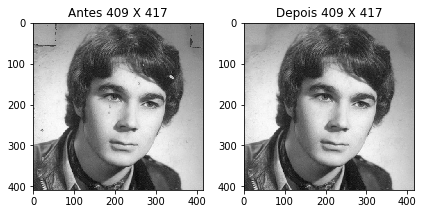

In [12]:
# Enquanto não estamos no topo da pirâmide
while (len(imgP) != 0):
    # Ampliar a imagem img
    img = ampliacionResolucion(img, 2, 2)
    
    # Obter as imagens salvas na lista
    imgA = imgP.pop()
    mascaraA = mascaraP.pop()

    # Mostrando a imagen obtida antes de copiar os novos pixels
    plt.subplot(1, 2, 1)
    plt.imshow(imgA, cmap=plt.cm.gray)
    plt.title("Antes " + str(imgA.shape[0]) + " X " + str(imgA.shape[1]))

    
    N = min(imgA.shape[0], img.shape[0])
    M = min(imgA.shape[1], img.shape[1])
    for i in np.arange(N):
        for j in np.arange(M):
            # Se a máscara indica o pixel desconhecido fazer
            if (mascaraA[i][j] != 0):
                # Copiar os pixels conhecidos da imagem ampliada para a imagem com pixels desconhecidos
                imgA[i][j] = img[i][j]

    # Mostrando a imagen obtida depois de copiar os novos pixels
    plt.subplot(1, 2, 2)
    plt.imshow(imgA, cmap=plt.cm.gray)
    plt.title("Depois " + str(imgA.shape[0]) + " X " + str(imgA.shape[1]))

    plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.05, right=0.99)
    plt.tight_layout()
    plt.show()
    
    # Substituir a nova imagem pela qual possui os pixels conhecidos
    img = imgA

## Resultado final

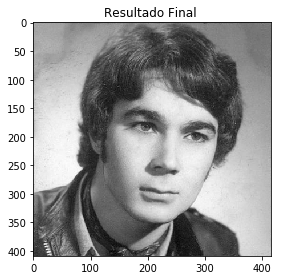

In [13]:
plt.imshow(img, cmap=plt.cm.gray)
plt.title("Resultado Final ")
plt.tight_layout()
plt.show()